# Crossing Clustering Analysis - OSM South Bay Work Zones
Goal:Develop spatially balanced zones of roughly equivalent number of pedestrian crossing elements for OSM contributors to validate as part of pedestrian network detailing in OpenStreetMap. Provide an example for others in Code for San Jose to work with geospatial data in python. 

Approach: Use KMeans Clustering on properly projected sidewalk data centroids to assemble clusters that can be transformed into work zones.Develop summary statistics on resulting groups from the clustering analysis. 

Libraries: Geopandas, Scipy, Scikit-Learn

In [44]:
import geopandas as gpd
from shapely.ops import nearest_points
import shapely.speedups
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
import matplotlib.style as mstyle
import os
mstyle.use("ggplot")
shapely.speedups.enable()

# Set Up Data Input & Plot

/content/datalab/notebooks


Text(0.5,1,u'TAZ')

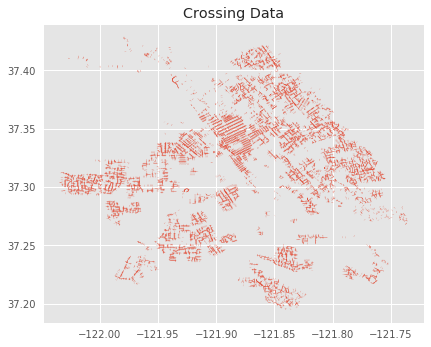

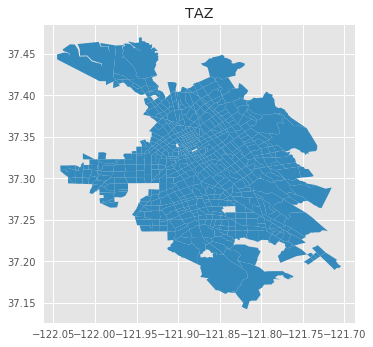

In [45]:
data_dir= r"/content/datalab/data"
print(os.getcwd())
crossings_df= gpd.read_file(os.path.join(data_dir,r"sj_most_formatted.geojson")).to_crs({"init":"epsg:4326"}) #Not Using Local State Plane 2227                                                              
taz_df= gpd.read_file(os.path.join(data_dir,r"sidewalks_tazs.geojson")).to_crs({"init":"epsg:4326"}) #Not Using Local State Plane 2227
output_dir = os.path.join(data_dir,"Output")
if not os.path.exists(output_dir):
  os.makedirs(output_dir)
crossings_df.plot().set_title("Crossing Data")
taz_df.plot().set_title("TAZ")

# Cluster Crossing Centroids XYs

In [46]:
crossings_df["X_Cent"]= crossings_df["geometry"].centroid.map(lambda p: p.x)
crossings_df["Y_Cent"]= crossings_df["geometry"].centroid.map(lambda p: p.y)
crossings_df["JoinID"]= crossings_df.index
display(crossings_df.head())

,highway,footway,surface,crossing_import,geometry,X_Cent,Y_Cent,JoinID
0,footway,crossing,paved,selector,LINESTRING (-122.0337681185583 37.303750858477...,-122.033748,37.303813,0
1,footway,crossing,paved,selector,LINESTRING (-122.0336680868601 37.303872489104...,-122.033674,37.303806,1
2,footway,crossing,paved,selector,LINESTRING (-122.0332392010799 37.303736639880...,-122.033239,37.303804,2
3,footway,crossing,paved,selector,LINESTRING (-122.033148590851 37.3038702252606...,-122.033149,37.303803,3
4,footway,crossing,paved,selector,LINESTRING (-122.0325937638638 37.312107428960...,-122.032622,37.312212,4


Text(0.5,1,u'KMEANS200')

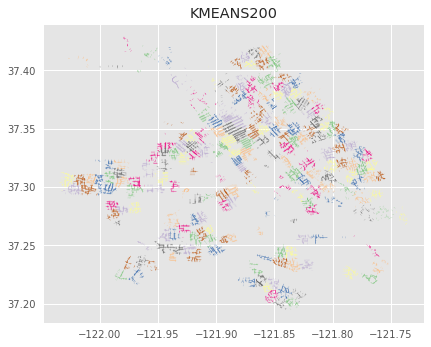

In [47]:
crossings_array= crossings_df[["X_Cent","Y_Cent"]].values
cluster_count =200
kmeans=KMeans(cluster_count).fit(crossings_array)
new_km_field="KMEANS{0}".format(cluster_count)
crossings_df[new_km_field] = pd.Series(kmeans.labels_)
crossings_df.plot(column=new_km_field,cmap="Accent").set_title(new_km_field)

# Develop Cluster Centers and Add to Dictionary

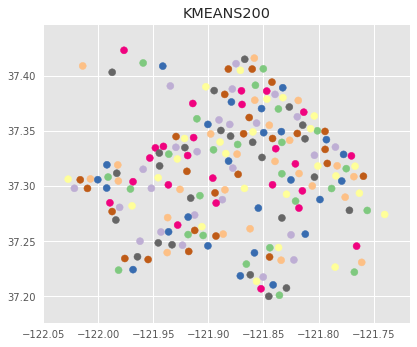

In [48]:
dissolved_cr= crossings_df.dissolve(by=new_km_field)
diss_centroids=dissolved_cr.centroid
cent_plot=diss_centroids.plot(cmap="Accent").set_title(str(new_km_field))

# Find Nearest TAZs associated with each Centroid - Generate New Polygon

a. Generate a function similar to [ArcPy's Near Analysis.](https://pro.arcgis.com/en/pro-app/tool-reference/analysis/near.htm) 

b. Use the function to associate cluster centroids with TAZs for zone creation. 

c. Associate TAZ zones with crossing data. Develop summary statistics. Export to GeoJSON.

In [68]:
def arc_near(target_df, near_df, src_field=None):
    """Adds a field to the target df by find the nearest point and adding its distance in a NEAR_DIST field 
   and the NEAR_INDEX if the SRC_Field is none. If it is not none, it will attempt to add the field chosen 
   of the closet geometry under a new column of the same title (NEAR_INDEX)."""
    nearest_data = []
    near_union_df = near_df.unary_union
    for index, row in target_df.iterrows():
        nearest_near_pt=nearest_points(row.geometry, near_union_df)[1]
        nearest= near_df.intersects(nearest_near_pt)
        if not nearest.any():
          continue
        if src_field == None:
            value = near_df[nearest].index.get_values()[0]
        else:
            value = near_df[nearest][src_field].get_values()[0]
        distance = row.geometry.distance(nearest_near_pt)
        nearest_data.append([index, value, distance])
    added_df = pd.DataFrame(nearest_data, columns=["JOIN_INDEX", "NEAR_INDEX", "NEAR_DIST"])
    return pd.merge(target_df, added_df, left_index=True, right_on="JOIN_INDEX")

Text(0.5,1,u'KMEANS200')

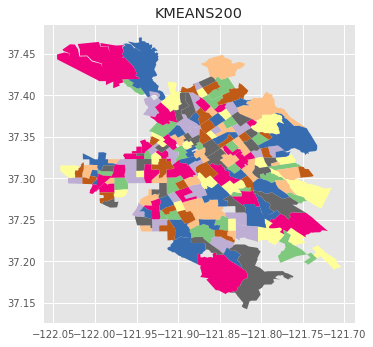

In [72]:
near_taz=arc_near(taz_df,diss_centroids)
near_taz_dis=near_taz.dissolve(by="NEAR_INDEX")
near_taz_dis.plot(cmap="Accent").set_title(str(new_km_field))

Text(0.5,1,u'KMEANS200')

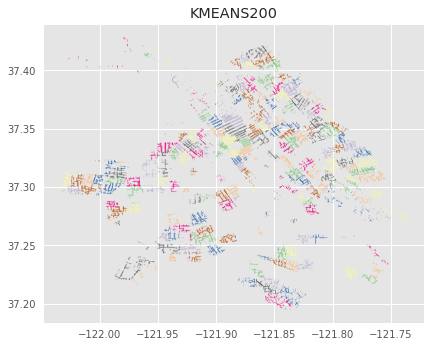

In [74]:
near_crossing_clusters=arc_near(crossings_df,near_taz_dis)
near_crossing_clusters_dis=near_crossing_clusters.dissolve(by="NEAR_INDEX")
near_crossing_clusters_dis.plot(cmap="Accent").set_title(str(new_km_field))

count    178.000000
mean     103.764045
std       52.511505
min        8.000000
25%       70.250000
50%      101.500000
75%      136.750000
max      391.000000
Name: highway, dtype: float64

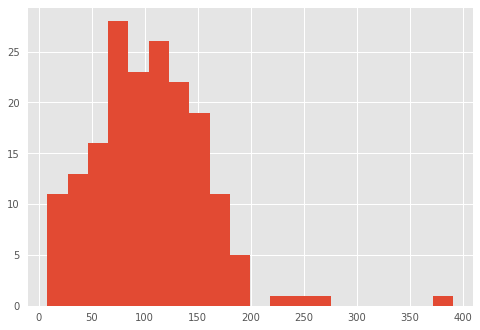

In [82]:
cluster_groups=near_crossing_clusters.groupby(by="NEAR_INDEX")
count=cluster_groups["highway"].count()
display(count.describe())
count.hist(bins=20)
plt.show()

In [71]:
out_taz_json= os.path.join(output_dir,"Cluster_TAZ_Shapes_{0}.geojson".format(str(new_km_field)))
try: 
    os.remove(out_taz_json)
except OSError:
    pass
near_taz_dis.to_file(filename=out_taz_json,driver='GeoJSON')
print("Data Export Complete")

Data Export Complete
